## Description
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
- - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals
- Evaluation

## Evaluation
- 자전거 대여량을 예측하는 문제다 듀란!
- 분류와 회귀중 회귀와 관련 된 문제이기 때문이다 듀란! 

In [1]:
## import pandas as pd
from datetime import datetime
import pandas as pd
import time
import numpy as np
import re
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
df_train = pd.read_csv('./data/bikesharing_train.csv',parse_dates=["datetime"],encoding = 'utf-8')
df_train.shape

(10886, 12)

In [3]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# df_train.columns
# df_train.info()

In [5]:
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## train data 상관계수를 알아보자 듀란!

In [6]:
# # 모든 feature값의 상관계수 알기 : 별... 상관 없다.... 
# df_train.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('tab20c'), axis=1)

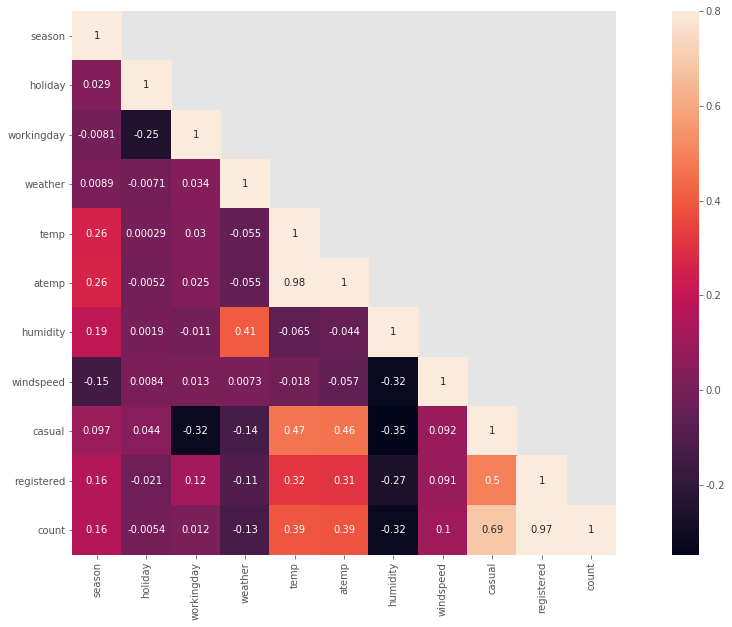

In [7]:
mask = np.array(df_train.corr()) #오른쪽 막대기듀란!
mask[np.tril_indices_from(mask)] = False #내부 네모네모즈 듀란!
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(df_train.corr(), mask=mask,vmax=.8, square=True,annot=True)

## datetime 피쳐값을 년,월,시간으로 뽀개기

In [8]:
# 듀란듀란! 날짜 뽀개기
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train["minute"] = df_train["datetime"].dt.minute
df_train["second"] = df_train["datetime"].dt.second
df_train.shape

(10886, 18)

In [9]:
# df_train.head(20)

## 피쳐값 조정을 위해 모든 변수 *시.각.화* 하자구욧!!!

C:\Users\dotst\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

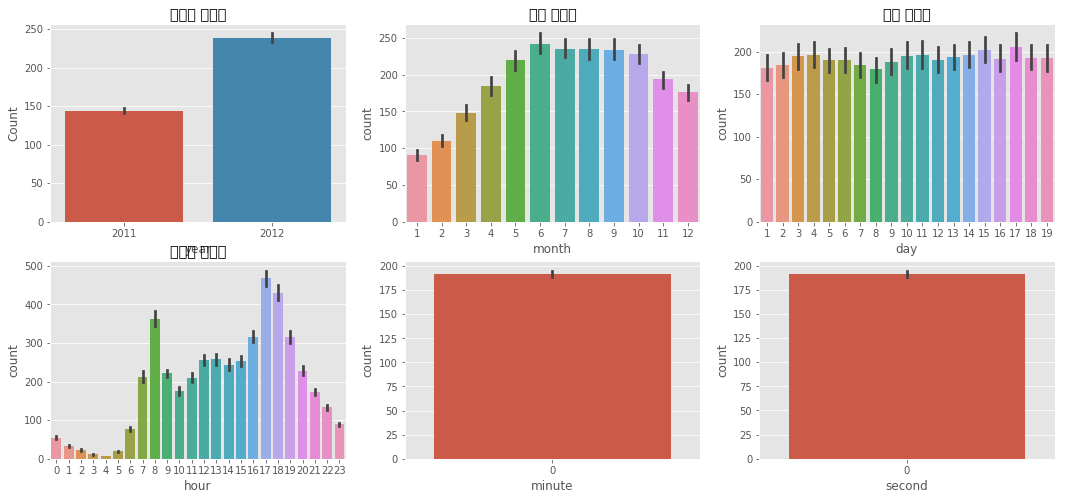

In [10]:
import seaborn as sns
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=df_train, x="year", y="count", ax=ax1)
sns.barplot(data=df_train, x="month", y="count", ax=ax2)
sns.barplot(data=df_train, x="day", y="count", ax=ax3)
sns.barplot(data=df_train, x="hour", y="count", ax=ax4)
sns.barplot(data=df_train, x="minute", y="count", ax=ax5)
sns.barplot(data=df_train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

- 연도별 대여량 2011 < 2012
- 월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
- 일별대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.
- 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
- 분, 초도 다 0이기 때문에 의미가 없다.

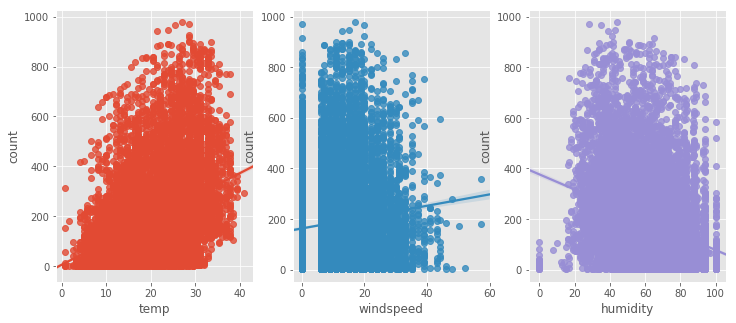

In [11]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=df_train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=df_train,ax=ax2)
sns.regplot(x="humidity", y="count", data=df_train,ax=ax3)

- 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다 듀란!
- 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

## count값도 노답쓰.. 노답쓰...정규화가 필요하다규!
## Outliers 구해서 조지자규!

In [12]:
# trainWithoutOutliers
df_trainWithoutOutliers = df_train[np.abs(df_train["count"] - df_train["count"].mean()) <= (3*df_train["count"].std())]

print(df_train.shape) #outlier 제거 전
print(df_trainWithoutOutliers.shape) #outlier제거 후 

(10886, 18)
(10739, 18)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

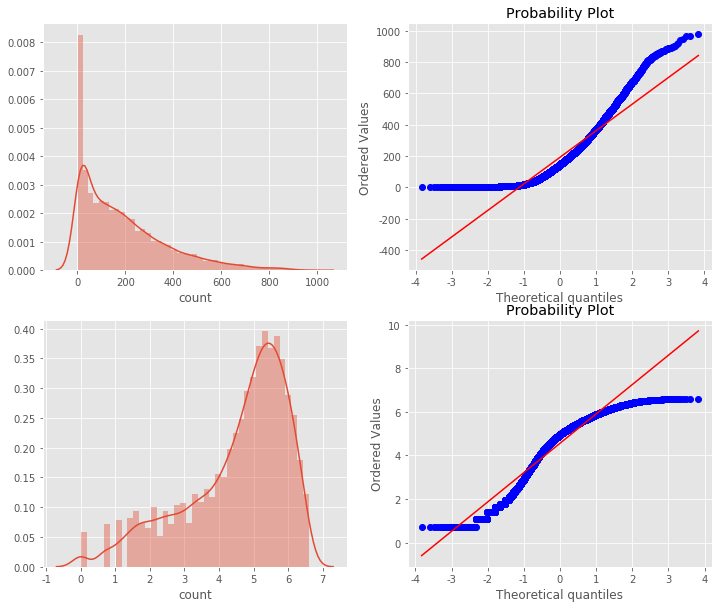

In [13]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(df_train["count"], ax=axes[0][0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(df_trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(df_trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

- count변수가 오른쪽에 치우쳐져 있다 듀란!
- 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다규
- 대안으로 outlier data를 제거하고! "count"변수에 로그를 씌워 변경해 봐도!
- 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다

In [14]:
# df_train.columns

In [15]:
# df_train.info()

In [16]:
# df_train['windspeed'].value_counts()

In [17]:
# df_train['season'].value_counts()

In [18]:
# df_train['holiday'].value_counts()

In [19]:
# df
# _train['workingday'].value_counts()

In [20]:
# df_train['weather'].value_counts()

In [21]:
# df_train['temp'].value_counts()

In [22]:
# df_train['atemp'].value_counts()

In [23]:
# df_train['humidity'].value_counts()

In [24]:
# df_train['casual'].value_counts()

In [25]:
# df_train['registered'].value_counts()

In [26]:
# tmp_wind = df_train.loc[['windspeed' == 0], 'windspeed']

## 자! 이제 풍속 0인거 조지자규 듀란

In [27]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다듀란
trainWind0 = df_train.loc[df_train['windspeed'] == 0]
trainWindNot0 = df_train.loc[df_train['windspeed'] != 0]

In [28]:
del trainWind0['windspeed']

In [29]:
trainWind0.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'casual', 'registered', 'count', 'year', 'month',
       'day', 'hour', 'minute', 'second'],
      dtype='object')

In [30]:
#windspeed 0이 아닌 모든 데이터프레임의 정규분포 값을 1313개구하다규
wind=np.random.normal(trainWindNot0['windspeed'].mean(), 1, 1313)
df_wind=pd.DataFrame(wind)
df_wind=df_wind.rename(columns={0:'windspeed'})
df_wind.head()

,windspeed
0,15.673199
1,13.259970
2,14.398854
3,14.711392
4,15.140412


In [31]:
# df_train['count'].value_counts()

In [32]:
# del df_train['atemp']

In [58]:
trainWind0 = trainWind0.reset_index(drop=True)
trainWind0.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,8,32,40,2011,1,1,1,0,0


In [35]:
# for i in len(df_train):
#     if df_train['windspeed'][i] == 0:
#         df_train['windspeedd'][i]

## 풍속 0 을 특정값으로 넣자규!

In [36]:
test = pd.concat([trainWind0,df_wind],axis = 1)
test
# del test['windspeed']

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,casual,registered,count,year,month,day,hour,minute,second,windspeed
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,3,13,16,2011,1,1,0,0,0,15.673199
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,8,32,40,2011,1,1,1,0,0,13.259970
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,5,27,32,2011,1,1,2,0,0,14.398854
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,3,10,13,2011,1,1,3,0,0,14.711392
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,1,1,2011,1,1,4,0,0,15.140412
5,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,2,0,2,2011,1,1,6,0,0,14.852260
6,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,1,2,3,2011,1,1,7,0,0,13.517508
7,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,1,7,8,2011,1,1,8,0,0,12.736021
8,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,8,6,14,2011,1,1,9,0,0,14.441432
9,2011-01-03 19:00:00,1,0,1,1,8.20,12.880,47,8,102,110,2011,1,3,19,0,0,12.382216


In [37]:
test.columns
test[['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'month',
       'day', 'hour', 'minute', 'second']]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,15.673199,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,13.259970,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,14.398854,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,14.711392,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,15.140412,0,1,1,2011,1,1,4,0,0
5,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,14.852260,2,0,2,2011,1,1,6,0,0
6,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,13.517508,1,2,3,2011,1,1,7,0,0
7,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,12.736021,1,7,8,2011,1,1,8,0,0
8,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,14.441432,8,6,14,2011,1,1,9,0,0
9,2011-01-03 19:00:00,1,0,1,1,8.20,12.880,47,12.382216,8,102,110,2011,1,3,19,0,0


In [38]:
trainWindNot0.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second'],
      dtype='object')

## 이제 풍속값0 조진 완전한 Train Data 탄생이라규!

In [39]:
test2 = pd.concat([test, trainWindNot0], axis=0)

C:\Users\dotst\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [40]:
test2

,atemp,casual,count,datetime,day,holiday,hour,humidity,minute,month,registered,season,second,temp,weather,windspeed,workingday,year
0,14.395,3,16,2011-01-01 00:00:00,1,0,0,81,0,1,13,1,0,9.84,1,15.673199,0,2011
1,13.635,8,40,2011-01-01 01:00:00,1,0,1,80,0,1,32,1,0,9.02,1,13.259970,0,2011
2,13.635,5,32,2011-01-01 02:00:00,1,0,2,80,0,1,27,1,0,9.02,1,14.398854,0,2011
3,14.395,3,13,2011-01-01 03:00:00,1,0,3,75,0,1,10,1,0,9.84,1,14.711392,0,2011
4,14.395,0,1,2011-01-01 04:00:00,1,0,4,75,0,1,1,1,0,9.84,1,15.140412,0,2011
5,13.635,2,2,2011-01-01 06:00:00,1,0,6,80,0,1,0,1,0,9.02,1,14.852260,0,2011
6,12.880,1,3,2011-01-01 07:00:00,1,0,7,86,0,1,2,1,0,8.20,1,13.517508,0,2011
7,14.395,1,8,2011-01-01 08:00:00,1,0,8,75,0,1,7,1,0,9.84,1,12.736021,0,2011
8,17.425,8,14,2011-01-01 09:00:00,1,0,9,76,0,1,6,1,0,13.12,1,14.441432,0,2011
9,12.880,8,110,2011-01-03 19:00:00,3,0,19,47,0,1,102,1,0,8.20,1,12.382216,1,2011


In [60]:
test2=test2[['season', 'holiday', 'workingday', 'weather', 'temp',
        'humidity', 'windspeed', 'year', 'month',
       'day', 'hour','count']]
# test2

In [42]:
# test2['temp'] =test2['temp'] / test2['temp'].max()
# test2['temp']

# test2['humidity'] =test2['humidity'] / test2['humidity'].max()
# test2['humidity']

test2['windspeed'] =test2['windspeed'] / test2['windspeed'].max()
test2['windspeed']

test2.head(10)
# X = X / X.max()
# X = X - X.mean(axis=1).reshape(len(X), 1)

C:\Users\dotst\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,count
0,1,0,0,1,9.84,81,0.274983,2011,1,1,0,16
1,1,0,0,1,9.02,80,0.232644,2011,1,1,1,40
2,1,0,0,1,9.02,80,0.252625,2011,1,1,2,32
3,1,0,0,1,9.84,75,0.258109,2011,1,1,3,13
4,1,0,0,1,9.84,75,0.265636,2011,1,1,4,1
5,1,0,0,1,9.02,80,0.260580,2011,1,1,6,2
6,1,0,0,1,8.20,86,0.237162,2011,1,1,7,3
7,1,0,0,1,9.84,75,0.223451,2011,1,1,8,8
8,1,0,0,1,13.12,76,0.253372,2011,1,1,9,14
9,1,0,1,1,8.20,47,0.217244,2011,1,3,19,110


In [43]:
# for i in range(len(test2['year'])):
#     if test2['year'][i] == 2011:
#         test2['year'][i] = 0
#     else:
#         test2['year'][i] = 1
# test2['year'][0]
# test2['year'].value_counts()

# test2['year'].value_counts()
test3=test2.drop(columns =['year'])
#  df.drop(columns=['B', 'C'])
test3.to_csv('./data/test3_bike.csv',encoding = 'utf-8')

In [44]:
# test2.to_csv('./data/test2_bike.csv', sep=',', encoding='utf-8')

In [45]:
# x_data = test2[['season', 'holiday', 'workingday', 'weather', 'temp',
#         'humidity', 'windspeed', 'year', 'month',
#        'day', 'hour']]
# y_data = test2[['count']]

In [46]:
test2.describe()

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,61.886460,0.255410,2011.501929,6.521495,9.992559,11.541613,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,19.245033,0.116781,0.500019,3.444373,5.476608,6.915838,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.000000,0.105325,2011.000000,1.000000,1.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,47.000000,0.157870,2011.000000,4.000000,5.000000,6.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,62.000000,0.243163,2012.000000,7.000000,10.000000,12.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,77.000000,0.298225,2012.000000,10.000000,15.000000,18.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,100.000000,1.000000,2012.000000,12.000000,19.000000,23.000000,977.000000


In [47]:
# test2['year'].unique()

# for i in range(len(test2)):
#     if str(test2['year'][i]) == '2011':
#         test2['year'][i] = '0'
#     else:
#         test2['year'][i] = '1'

In [48]:
test2['year'].value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [49]:
type(test2['windspeed'][0])

numpy.float64

In [50]:
# from tqdm import tqdm_notebook
# import tensorflow as tf
# import random
# import matplotlib.pyplot as plt

# from tensorflow.examples.tutorials.mnist import input_data

In [51]:
# def xavier_init(n_inputs, n_outputs, uniform=True):
#     if uniform:
#         # 6 was used in the paper.
#         init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
#         return tf.random_uniform_initializer(-init_range, init_range)
#     else:
#         # 3 gives us approximately the same limints as above since this repicks
#         # values greater than 2 standard deviations from the mean.
#         stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
#         return tf.truncated_normal_initializer(stddev=stddev)

In [52]:
# import tensorflow as tf
# import numpy as np

# tf.set_random_seed(777)  # for reproducibility

# # np.loadtxt('./data/test2_bike.csv', delimiter=',', dtype=np.float32)
# xy = np.loadtxt('./data/test3_bike.csv', delimiter=',', skiprows=1, dtype=np.int32)
# x_data = xy[:, 1:-1]
# y_data = xy[:, [-1]]

# # Make sure the shape and data are OK
# print("x_data.shape : {}, \tlen(x_data) : {} \nx_data : \n{}".format(x_data.shape, len(x_data), x_data))
# print("-"*25)
# print("y_data.shape : {}  \ny_data : \n{}".format(y_data.shape, y_data))

# # placeholders for a tensor that will be always fed.
# X = tf.placeholder(tf.float32, shape=[None, 10])
# Y = tf.placeholder(tf.float32, shape=[None, 1])

# W1 = tf.Variable(tf.random_normal([10, 128]), name='weight')
# b1 = tf.Variable(tf.random_normal([128]), name='bias')
# L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

# W2 = tf.Variable(tf.random_normal([128, 128]), name='weight2')
# b2 = tf.Variable(tf.random_normal([128]), name='bias2')
# L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

# W3 = tf.Variable(tf.random_normal([128, 128]), name='weight3')
# b3 = tf.Variable(tf.random_normal([128]), name='bias3')
# L3 = tf.nn.relu(tf.matmul(L1, W2) + b2)

# W4 = tf.Variable(tf.random_normal([128, 1]))
# b4 = tf.Variable(tf.random_normal([1]))

# # Hypothesis
# hypothesis = tf.matmul(L3, W4) + b4

# # Simplified cost/loss function
# cost = tf.reduce_mean(tf.square(hypothesis - Y))

# # Minimize
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-8)
# train = optimizer.minimize(cost)

In [53]:
# optimizer, cost, hypothesis
# # train

In [54]:
# from tqdm import tqdm_notebook

In [55]:
# # Launch the graph in a session.
# sess = tf.Session()
# # Initializes global variables in the graph.
# sess.run(tf.global_variables_initializer())

# for step in tqdm_notebook(range(100001)):
#     cost_val, hy_val, t_val = sess.run(
#         [cost, hypothesis, train], feed_dict={X: x_data, Y: y_data})

#     if step % 1000 == 0 or step < 10 : 
#         print("\nStep : {} \nCost : {} \nPrediction :\n{}".format(step, cost_val, t_val))
#         print("Step : {} \tCost : {} ".format(step, cost_val))
        

In [56]:
# Launch the graph in a session.
sess = tf.Session()
# Initializes global variables in the graph.
sess.run(tf.global_variables_initializer())

for step in tqdm_notebook(range(100001)):
    cost_val, hy_val, t_val = sess.run(
        [cost, hypothesis, train], feed_dict={X: x_data, Y: y_data})
    if step % 1000 == 0 or step < 10 : 
        print("\nStep : {} \nCost : {} \nPrediction :\n{}".format(step, cost_val, t_val))
        print("Step : {} \tCost : {} ".format(step, cost_val))
        

NameError: name 'tqdm_notebook' is not defined